In [97]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from pandas.tseries.offsets import BDay
import pandas_market_calendars as mcal
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [99]:
# Fetch Nike data
data = yf.download('NKE', '2000-01-01', '2024-09-30')
data = pd.DataFrame(data)
data.reset_index(inplace=True)

# Fetch NYSE holiday calendar
nyse = mcal.get_calendar('NYSE')
holidays = nyse.holidays().holidays

# Add a column to mark weekly expiry dates
def mark_weekly_expiry(dates):
    expiry_flags = []
    for date in dates:
        if date.weekday() == 4:  # Check if it's Friday
            if date in holidays:  # If Friday is a holiday, move to Thursday
                expiry_flags.append(1 if (date - BDay(1)) in dates.values else 0)
            else:
                expiry_flags.append(1)
        else:
            expiry_flags.append(0)
    return expiry_flags

data['is_weekly_expiry'] = mark_weekly_expiry(data['Date'])


[*********************100%***********************]  1 of 1 completed


In [100]:
# Add Moving Averages to the data
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Fill NA values created by rolling averages
data.fillna(method='bfill', inplace=True)

# Drop unnecessary columns
date_column = data['Date']
data.drop(columns=['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)


C:\Users\Hp\AppData\Local\Temp\ipykernel_3260\4255933376.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [103]:
# Split the data into train and test sets
train_data = data[:-200]  # Train on all but the last 200 rows
test_data = data[-200:]  # Test on the last 200 rows

# Print shapes for verification
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (6024, 4)
Test Data Shape: (200, 4)


In [105]:
# Scale train and test data independently
features = ['Close', 'MA_10', 'MA_20']

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

# Convert back to DataFrame for easier handling
train_scaled = pd.DataFrame(train_scaled, columns=features, index=train_data.index)
test_scaled = pd.DataFrame(test_scaled, columns=features, index=test_data.index)


In [107]:
# Prepare sequences for the LSTM model
base_days = 100
x_train, y_train = [], []

for i in range(base_days, train_scaled.shape[0]):
    x_train.append(train_scaled.iloc[i-base_days:i].values)  # Use all features
    y_train.append(train_scaled.iloc[i]['Close'])           # Target is 'Close'

x_train, y_train = np.array(x_train), np.array(y_train)

x_test, y_test = [], []
test_combined = pd.concat([train_scaled.tail(base_days), test_scaled])  # Append tail of train to test

for i in range(base_days, test_combined.shape[0]):
    x_test.append(test_combined.iloc[i-base_days:i].values)  # Use all features
    y_test.append(test_combined.iloc[i]['Close'])           # Target is 'Close'

x_test, y_test = np.array(x_test), np.array(y_test)


In [109]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))  # Predict only 'Close'

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)


C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - loss: 0.0179
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - loss: 0.0036
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - loss: 0.0038
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - loss: 0.0031
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - loss: 0.0026
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - loss: 0.0026
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.0025
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 0.0029
Epoch 9/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0027
Epoch 10/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0026
Epoch 11/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 0.0023
Epoch 12/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - loss: 0.0020
Epoch 13/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - loss: 0.0021
Epoch 14/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0023
Epoch 15/50
186/1

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 893ms/step


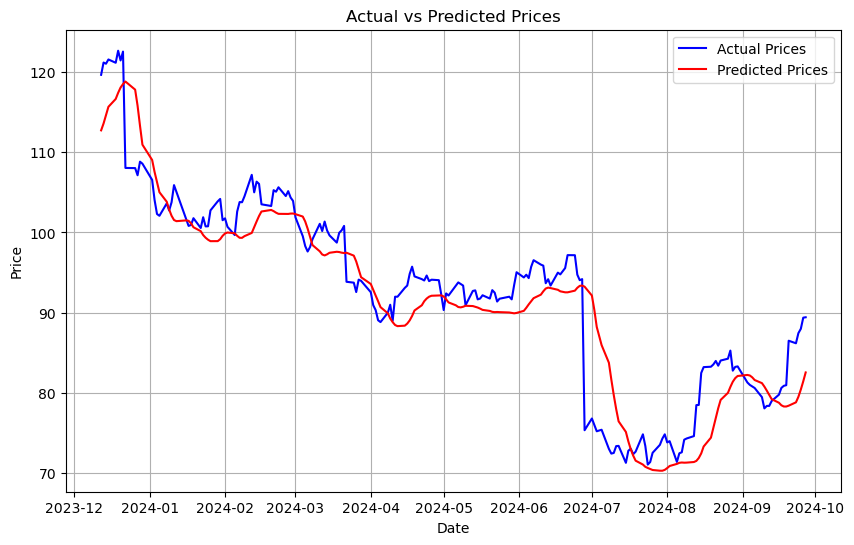

Model Evaluation Metrics:
Mean Absolute Error (MAE): 3.4203657361491038
Mean Squared Error (MSE): 20.19794515237107
R² Score: 0.859622006707491


In [111]:
# Predict on test data
pred_test = model.predict(x_test)

# Inverse transform predictions and actual values
pred_test = scaler.inverse_transform(
    np.concatenate([pred_test, np.zeros((pred_test.shape[0], 2))], axis=1)
)[:, 0]
y_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))], axis=1)
)[:, 0]

# Get test dates
test_dates = date_column.iloc[-len(y_actual):]

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_actual, label="Actual Prices", color="blue")
plt.plot(test_dates, pred_test, label="Predicted Prices", color="red")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Calculate evaluation metrics
mae = mean_absolute_error(y_actual, pred_test)
mse = mean_squared_error(y_actual, pred_test)
r2 = r2_score(y_actual, pred_test)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

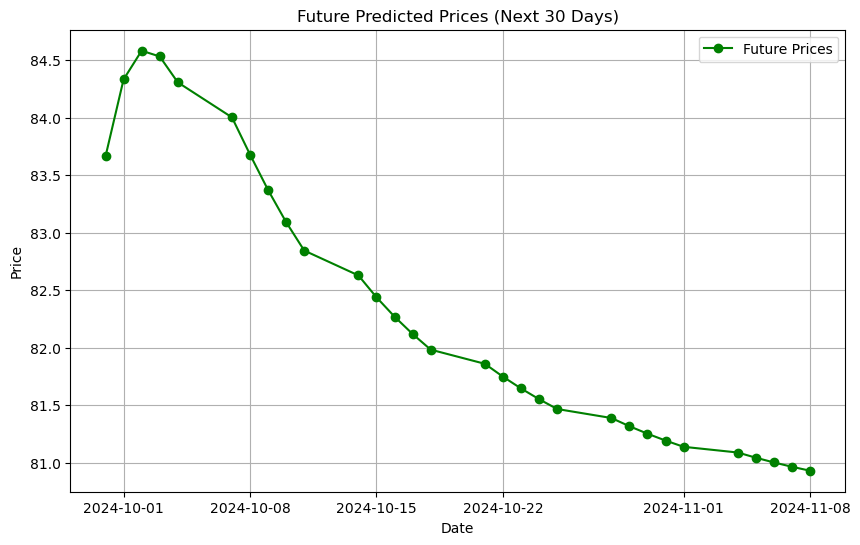

In [113]:
# Future price prediction
m = test_combined.iloc[-base_days:].values  # Start with the last base_days
z = []
future_days = 30

for i in range(future_days):
    inter = [m[-base_days:]]
    inter = np.array(inter)
    inter = np.reshape(inter, (inter.shape[0], inter.shape[1], len(features)))
    pred = model.predict(inter)
    z.append(pred[0][0])
    new_row = np.array([pred[0][0], m[-1, 1], m[-1, 2]])  # Keep MA_10 and MA_20 static
    m = np.vstack((m, new_row))  # Update for next iteration

z = np.array(z).reshape(-1, 1)
z = scaler.inverse_transform(np.concatenate([z, z, z], axis=1))[:, 0]  # Inverse transform only 'Close'

# Generate future dates
last_date = date_column.iloc[-1]
future_dates = pd.date_range(start=last_date, periods=future_days + 1, freq='B')[1:]

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, z, marker="o", color="green", label="Future Prices")
plt.title("Future Predicted Prices (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [115]:
# Save the model
model.save("Nike_Price_Prediction_Model.keras")
